<a href="https://colab.research.google.com/github/DarkPovoGang/DeepRL/blob/main/DeepRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project

## Dataset preparation

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-feps4jcf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-feps4jcf
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch version:", torch.__version__)
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

preprocess

Torch version: 2.0.1+cu118
Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f35eab50ee0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
import pandas as pd
import os
import gdown
import tarfile
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class RefCOCOg(Dataset):

  FILE_ID = '1wyyksgdLwnRMC9pQ-vjJnNUn47nWhyMD'
  ARCHIVE_NAME = 'refcocog.tar.gz'
  NAME = 'refcocog'
  ANNOTATIONS = 'annotations/refs(umd).p'
  IMAGES = 'images'
  IMAGE_NAME = 'COCO_train2014_{}.jpg'


  def __init__(self, data_dir, split, transform=None):
      self.data_dir = data_dir
      self._check_dataset()
      self.split = split
      self._filter_annotation(os.path.join(self.data_dir, self.NAME, self.ANNOTATIONS))
      self.transform = transform

  def _check_dataset(self):
      if not os.path.exists(os.path.join(self.data_dir, self.ARCHIVE_NAME)):
          if not os.path.exists(self.data_dir):
              os.mkdir(self.data_dir)
          print('Downloading dataset...')
          gdown.download(id=self.FILE_ID)
      if not os.path.exists(os.path.join(self.data_dir, self.NAME)):
          print('Extracting dataset...')
          with tarfile.open(os.path.join(self.data_dir, self.ARCHIVE_NAME), 'r:gz') as tar:
              tar.extractall(path=self.data_dir)
      else:
          print('Dataset already extracted')

  def __len__(self):
      return len(self.annotation)

  def __getitem__(self, idx):
      # get line by index
      raw = self.annotation.iloc[idx]
      # get image
      image = self._get_image(raw)
      # get sentences
      sentences = self._get_sentences(raw)

      return self._get_vectors(image, sentences)

  def _get_image(self, raw):
      # get image_id
      image_id = raw['image_id']
      # pad image_id to 12 digits
      image_id = str(image_id).zfill(12)
      # convert image to tensor
      image = Image.open(os.path.join(self.data_dir, self.NAME, self.IMAGES, self.IMAGE_NAME.format(image_id)))
      return image

  def _get_sentences(self, raw):
      # get sentences
      sentences = raw['sentences']
      # get raw sentences
      sentences = [sentence['raw'] for sentence in sentences]
      return sentences

  def _filter_annotation(self, path):
      # self.annotation = pd.read_pickle(path)
      # #self.annotation = pd.DataFrame([x for x in (self.annotation) if x['split'] == 'val'])
      # self.annotation = [x for x in (self.annotation) if x['split'] == 'val']
      # self.ANNOTATION_SIZE = len(self.annotation)
      self.annotation = pd.read_pickle(path)
      self.annotation = pd.DataFrame(self.annotation)
      self.annotation = self.annotation[self.annotation['split'] == self.split]

  def _get_vectors(self, image, sentences):
  # TODO: check multiple sentences
    image = preprocess(image).unsqueeze(0).to(device)
    text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
      image_features = model.encode_image(image)
      text_features = model.encode_text(text)
    print(f"Image shape: {image_features.shape}, Text shape:{text_features.shape}")
    product = np.multiply(image_features.cpu(), text_features.cpu())
    out = product / np.linalg.norm(product)
    print(f"Output shape: {out.shape}")
    return out

In [ ]:
dataset = RefCOCOg('.', 'val')
for i in range(5):
  x = dataset[i]
  print(x)

Dataset already extracted
Image shape: torch.Size([1, 1024]), Text shape:torch.Size([2, 1024])
Output shape: torch.Size([2, 1024])
tensor([[ 2.9540e-04,  8.5831e-04,  2.9221e-03,  ..., -2.7275e-04,
         -5.6171e-04, -1.9217e-03],
        [-4.7755e-04,  1.4048e-03,  2.5578e-03,  ..., -8.1658e-05,
         -1.2970e-04, -3.8681e-03]], dtype=torch.float16)
Image shape: torch.Size([1, 1024]), Text shape:torch.Size([2, 1024])
Output shape: torch.Size([2, 1024])
tensor([[-0.0016, -0.0002, -0.0037,  ..., -0.0004, -0.0003, -0.0104],
        [-0.0014, -0.0003, -0.0053,  ...,  0.0002, -0.0002,  0.0007]],
       dtype=torch.float16)
Image shape: torch.Size([1, 1024]), Text shape:torch.Size([2, 1024])
Output shape: torch.Size([2, 1024])
tensor([[-6.6996e-04,  1.7273e-04,  2.8372e-04,  ..., -2.2161e-04,
          8.2541e-04, -2.2030e-03],
        [-8.0252e-04, -3.8028e-04, -1.6422e-03,  ...,  1.4365e-05,
          2.4033e-03,  4.4322e-04]], dtype=torch.float16)
Image shape: torch.Size([1, 1024])

## Reinforcement Learning Setup with PPO2

In [4]:
!pip install torchrl
!pip install gym[mujoco]
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 24.9 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [ ]:
device = "cpu" if not torch.has_cuda else "cuda:0"
num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0

In [ ]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000 // frame_skip

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [ ]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

In [ ]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(
            in_keys=["observation"],
        ),
        StepCounter(),
    ),
)

In [ ]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [ ]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [ ]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("done_spec:", env.done_spec)
print("action_spec:", env.action_spec)
print("state_spec:", env.state_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
         shape=torch.Size([11]), space=None, device=cuda:0, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)), device=cuda:0, dtype=torch.int64, domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cuda:0, dtype=torch.float32, domain=continuous)
done_spec: DiscreteTensorSpec(
     shape=torch.Size([1]), space=DiscreteBox(n=2), device=cuda:0, dtype=torch.bool, domain=di

AttributeError: ignored

In [ ]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
            batch_size=torch.Size([3]),
            device=cuda:0,
            is_shared=True),
        observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([3, 1]), devi

In [ ]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [ ]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [ ]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [ ]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), de

In [ ]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [ ]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [ ]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

/usr/local/lib/python3.10/dist-packages/torchrl/objectives/ppo.py:163: DeprecationWarning: Passing gamma / lambda parameters through the loss constructor is deprecated and will be removed soon. To customize your value function, run `loss_module.make_value_estimator(ValueEstimators.<value_fun>, gamma=val)`.
  warnings.warn(_GAMMA_LMBDA_DEPREC_WARNING, category=DeprecationWarning)


In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        with torch.no_grad():
            advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()


eval cumulative reward:  194.8776 (init:  194.8776), eval step-count: 20, average reward= 9.2776 (init= 9.2491), step count (max): 81, lr policy:  0.0003:  50%|█████     | 5000.0/10000.0 [02:43<02:43, 30.64it/s]

  5%|▌         | 500.0/10000.0 [00:08<02:33, 61.96it/s]
eval cumulative reward:  35.1045 (init:  35.1045), eval step-count: 3, average reward= 9.2863 (init= 9.2863), step count (max): 65, lr policy:  0.0300:   5%|▌         | 500.0/10000.0 [00:08<02:33, 61.96it/s]
eval cumulative reward:  35.1045 (init:  35.1045), eval step-count: 3, average reward= 9.2863 (init= 9.2863), step count (max): 65, lr policy:  0.0300:  10%|█         | 1000.0/10000.0 [00:17<02:35, 57.81it/s]
eval cumulative reward:  35.1045 (init:  35.1045), eval step-count: 3, average reward= 8.8714 (init= 9.2863), step count (max): 17, lr policy:  0.0293:  10%|█         | 1000.0/10000.0 [00:17<02:35, 57.81it/s]
eval cumulative reward:  35.1045 (init:  35.1045), eval step-count: 3, average reward= 8.8714 (init= 9.2

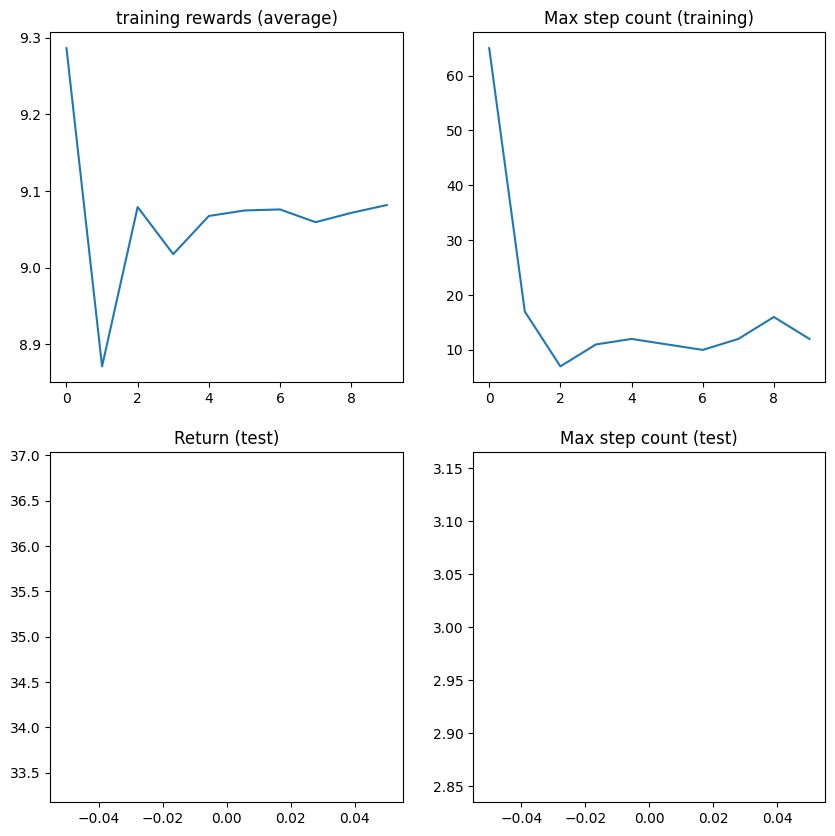

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

## Custom Environment

In [6]:
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

# DEFAULT_X = np.pi
# DEFAULT_Y = 1.0

In [9]:
class VisualGroundingEnv(EnvBase):
  def __init__(self, td_params=None, seed=None, device="cpu"):
    if td_params is None:
      td_params = self.gen_params()

    super().__init__(device=device, batch_size=[])
    self._make_spec(td_params)
    if seed is None:
      seed = torch.empty((), dtype=torch.int64).random_().item()
      self.set_seed(seed)

  def _step(self, tensordict):
    pass

  def _reset(self, tensordict):
    pass

  def _set_seed(self, seed: Optional[int]):
    pass

  def gen_params(self, something=0, batch_size=None) -> TensorDictBase:
    pass

  def _make_spec(self, td_params):
    pass

  def make_composite_from_td(td):
    pass

In [10]:
env = VisualGroundingEnv()
check_env_specs(env)

KeyError: ignored